# Problem 5.5 
# Implementation of BackProbagation

In [1]:
import numpy as np
import pandas as pd
import random
import copy 

from IPython.display import Image, display

In [2]:
data = pd.read_csv('../data/data.txt')

In [3]:
data.head()

,Id,color,root,sound,stripes,umbilical,touch,density,sugar,quality
0,1,dark-green,roll-up,dull,clear,hollow,hard,0.697,0.460,good
1,2,pitch-dark,roll-up,dead,clear,hollow,hard,0.744,0.376,good
2,3,pitch-dark,roll-up,dull,clear,hollow,hard,0.634,0.264,good
3,4,dark-green,roll-up,dead,clear,hollow,hard,0.608,0.318,good
4,5,white,roll-up,dull,clear,hollow,hard,0.556,0.215,good


In [4]:
data.columns

Index(['Id', 'color', 'root', 'sound', 'stripes', 'umbilical', 'touch',
       'density', 'sugar', 'quality'],
      dtype='object')

# 1. Pre-Processing - dummy variables

In [5]:
def dummies_fit(df):
    dummies_dict = {}
    for column in df.columns:
        if not np.issubdtype(df[column].dtype, np.number):
            dummies_dict[column] = {}
            i = 0
            for value in set(df[column].values):
                dummies_dict[column][value] = i
                i += 1
    return dummies_dict

In [6]:
def dummies_transfer(df, dum_dict):
    for column in df.columns:
        if column in dum_dict.keys():
            for key in dum_dict[column]:
                df.loc[df[column] == key, column] = dum_dict[column][key]

In [7]:
d = dummies_fit(data.drop(['Id'],axis=1))
d

{'color': {'dark-green': 1, 'pitch-dark': 0, 'white': 2},
 'quality': {'bad': 1, 'good': 0},
 'root': {'roll-up': 1, 'slighly-curled': 0, 'stiff': 2},
 'sound': {'crisp': 2, 'dead': 1, 'dull': 0},
 'stripes': {'blurred': 1, 'clear': 0, 'indistinct': 2},
 'touch': {'hard': 0, 'soft': 1},
 'umbilical': {'hollow': 1, 'plain': 0, 'slightly-hollow': 2}}

In [8]:
dummies_transfer(data, d)

In [9]:
data = data.drop(['Id'],axis=1)

In [10]:
data.head()

,color,root,sound,stripes,umbilical,touch,density,sugar,quality
0,1,1,0,0,1,0,0.697,0.460,0
1,0,1,1,0,1,0,0.744,0.376,0
2,0,1,0,0,1,0,0.634,0.264,0
3,1,1,1,0,1,0,0.608,0.318,0
4,2,1,0,0,1,0,0.556,0.215,0


# 1. Initialize Network

In [11]:
def initialize_network(n_inputs, n_hidden, n_outputs, seed=0):
    """
    This function return the initialized network and this network has a struction of
    one hidden layer.
    
    It has four inputs:
    1. n_inputs: integer, the number of inputs
    2. n_hidden: integer, the number of hidden neurons
    3. n_outputs: integer, the number of output neurons
    4. seed: set the seed
    """
    random.seed(seed)
    network = {}
    network['hidden'] = [[random.random() for i in range(n_inputs + 1)] for i in range(n_hidden)]
    network['output'] = [[random.random() for i in range(n_hidden+1)] for i in range(n_outputs)]
    
    return network
    
    

In [12]:
init_network = initialize_network(data.shape[1]-1, 4, 2)

In [13]:
init_network

{'hidden': [[0.8444218515250481,
   0.7579544029403025,
   0.420571580830845,
   0.25891675029296335,
   0.5112747213686085,
   0.4049341374504143,
   0.7837985890347726,
   0.30331272607892745,
   0.4765969541523558],
  [0.5833820394550312,
   0.9081128851953352,
   0.5046868558173903,
   0.28183784439970383,
   0.7558042041572239,
   0.6183689966753316,
   0.25050634136244054,
   0.9097462559682401,
   0.9827854760376531],
  [0.8102172359965896,
   0.9021659504395827,
   0.3101475693193326,
   0.7298317482601286,
   0.8988382879679935,
   0.6839839319154413,
   0.47214271545271336,
   0.1007012080683658,
   0.4341718354537837],
  [0.6108869734438016,
   0.9130110532378982,
   0.9666063677707588,
   0.47700977655271704,
   0.8653099277716401,
   0.2604923103919594,
   0.8050278270130223,
   0.5486993038355893,
   0.014041700164018955]],
 'output': [[0.7197046864039541,
   0.39882354222426875,
   0.824844977148233,
   0.6681532012318508,
   0.0011428193144282783],
  [0.4935778664653246

# 2. Forward Propagation

Forward propagation can be broken down into three parts:

1. Neuron Activation.
2. Neuron Transfer.
3. Forward Propagation.

- Activation 
 
 $$activation = \sum_{i=1}^{I} (weight_{i} * input_{i}) - threshold $$

In [14]:
def activate(weights, inputs):
    weight, threshold = weights[:-1], weights[-1]
    value = np.dot(weight, inputs) - threshold
    return value

-  Sigmoid Transformation

$$ output = \frac{1}{1+e^{-z}} $$ 
$$ $$
$$ z = - activation $$

In [15]:
def transformation(z):
    return 1.0/(1.0+np.exp(-z))

- Forward propagation

activation -> output -> input -> activation -> ..

In [16]:
def forward_propagation(network_dict, row):
    """
    This function returns the outputs from the output layers
    It has two inputs:
    1. network_dict: dictionary, {'hidden':[[w1, w2, .. ,b], [...]], 'output': [[w1,...]]}
    2. row: a row of input variables
    """
    updated_inputs = [] # the list of final outputs
    hidden_output = [] # the list of output from hidden layer
    
    # compute the output of each hidden neuron
    for i in range(len(network_dict['hidden'])):
        activation = activate(network_dict['hidden'][i], row) 
        transform = transformation(activation)
        hidden_output.append(transform)
    
    # compute the output of each output neuron
    for i in range(len(network_dict['output'])):
        beta = transformation(activate(network_dict['output'][i], hidden_output))
        updated_inputs.append(beta)
    return updated_inputs, hidden_output

In [18]:
s_d = data.drop(['quality'],axis=1)
b = forward_propagation(init_network, s_d.iloc[0])
b

([0.91730335846414202, 0.70436307737895776],
 [0.91075475315638799,
  0.86501694571825016,
  0.92773831543430474,
  0.960405764593113])

# 3. Standard Back-Propagation

This part can be broken down into two sections.

1. Transfer Derivative.
2. Error Backpropagation.

-  Derivation of Sigmoid Function:
$$ f(x) = \frac{1}{1+e^{-z}}  $$
$$ $$
$$f^{\prime}(x) = f(x)(1-f(x))  $$

In [19]:
def derivation(v):
    return v*(1-v)

- Standard back propagation

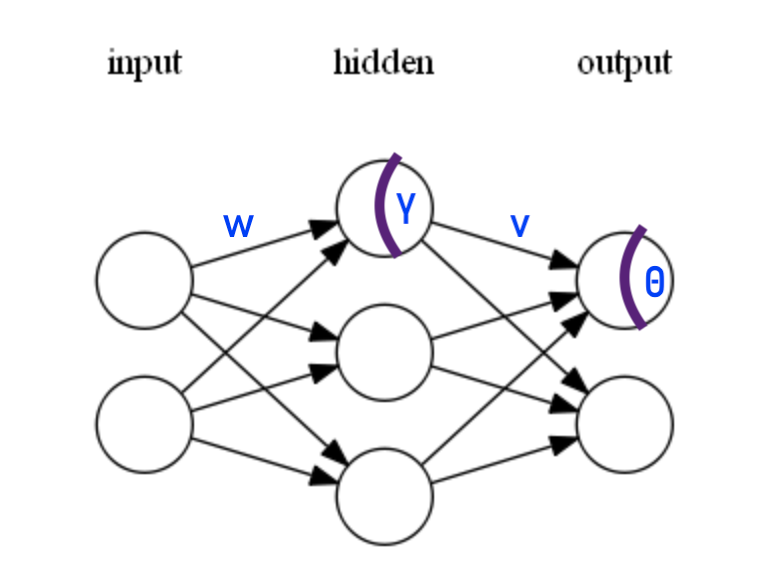

In [20]:
display(Image("../image/image1.png"))

$$ \forall v \in Parameters $$
$$ $$
$$ v \gets v + \triangledown v$$
$$ $$
$$ \triangledown w_{hj} = \eta g_{j} b_{h} $$
$$ $$
$$ \triangledown v_{ih} = \eta e_{h} x_{i} $$
$$ $$
$$ \triangledown \theta_{j} = -\eta g_{j} $$
$$ $$
$$ \triangledown \gamma_{j} = -\eta e_{h} $$

$$ g_{j} = \hat{y}_{j} (1-\hat{y}_{j}) ({y}_{j}-\hat{y}_{j}) $$
$$ $$
$$ e_{h} = b_{h}(1-b_{h})\sum_{j=1}{l}w_{hj}g_{j}$$
$$ $$

In [21]:
def standard_back_probagation(network_dict, input_row, train_value, learning_rate):
    """
    This function returns the updated network weights after iterating through 1 row. 
    It has four variables:
    1. network_dict: dictionary, the initialized network
    2. input_row: df row, the train data
    3. train_value: the train target value of this row
    4. learning_rate: float
    """
    y_hat, b = forward_propagation(network_dict, input_row)
    y = [0.0 for i in range(len(y_hat))]
    y[train_value]=1.0
    
    g_list = []
    updated_network_dict = copy.deepcopy(network_dict)
    
    for i in range(len(network_dict['output'])):
        g = y_hat[i] * (1 - y_hat[i])*(y[i] - y_hat[i])
        
        g_list.append(g)
        updated_network_dict['output'][i][-1] -= learning_rate * g
        for j in range(len(network_dict['output'][i]) -1):
            updated_network_dict['output'][i][j] += learning_rate * g * b[j]
            
    for i in range(len(network_dict['hidden'])):
        w_h = [parameters[i] for parameters in network_dict['output']]
        product_sum = sum([w_hj * g_j for (w_hj, g_j) in zip(w_h, g_list)])
        e = b[i] * (1-b[i]) * product_sum
        
        updated_network_dict['hidden'][i][-1] -= learning_rate * e
        
        for j in range(len(network_dict['hidden']) -1):
            updated_network_dict['hidden'][i][j] += learning_rate * e * input_row[j]
            
    return updated_network_dict        

In [22]:
standard_back_probagation(init_network, s_d.iloc[0], data.quality[0], 0.5)

{'hidden': [[0.84166319120649191,
   0.75519574262174627,
   0.420571580830845,
   0.25891675029296335,
   0.5112747213686085,
   0.4049341374504143,
   0.7837985890347726,
   0.30331272607892745,
   0.47935561447091207],
  [0.57609882499387854,
   0.90082967073418252,
   0.50468685581739026,
   0.28183784439970383,
   0.7558042041572239,
   0.6183689966753316,
   0.25050634136244054,
   0.9097462559682401,
   0.99006869049880575],
  [0.80919149604238849,
   0.90114021048538162,
   0.31014756931933263,
   0.7298317482601286,
   0.8988382879679935,
   0.6839839319154413,
   0.47214271545271336,
   0.1007012080683658,
   0.43519757540798476],
  [0.61005975515653887,
   0.91218383495063549,
   0.96660636777075881,
   0.47700977655271704,
   0.8653099277716401,
   0.2604923103919594,
   0.8050278270130223,
   0.5486993038355893,
   0.014868918451281642]],
 'output': [[0.72256135709603386,
   0.40153675184345738,
   0.8277549184320262,
   0.67116560714102591,
   -0.0019937777575929749],
  [

# 4. Accumulated Back-Propagation

$$ \forall v \in Parameters $$
$$ $$
$$ v \gets v + \triangledown v$$
$$ $$
$$ \triangledown w_{hj} = \sum\eta g_{j} b_{h} $$
$$ $$
$$ \triangledown v_{ih} = \sum\eta e_{h} x_{i} $$
$$ $$
$$ \triangledown \theta_{j} = -\sum\eta g_{j} $$
$$ $$
$$ \triangledown \gamma_{j} = -\sum\eta e_{h} $$

$$ g_{j} = \hat{y}_{j} (1-\hat{y}_{j}) ({y}_{j}-\hat{y}_{j}) $$
$$ $$
$$ e_{h} = b_{h}(1-b_{h})\sum_{j=1}{l}w_{hj}g_{j}$$
$$ $$

In [23]:
def accumulated_back_propagation(network_dict, input_df, target_name, learning_rate):
    """
    This function returns the updated network weights after 1 round. 
    It has four variables:
    1. network_dict: dictionary, the initialized network
    2. input_df: df, the train data
    3. target_name: string, the column name of target 
    4. learning_rate: float
    """
    train_x, train_y = input_df.drop([target_name],axis=1), input_df[target_name]
    delta_dict = {'hidden': np.zeros(np.array(network_dict['hidden']).shape),
                  'output': np.zeros(np.array(network_dict['output']).shape)}
    
    
    for index in range(len(input_df)):
        input_row, train_value = train_x.iloc[index], train_y[index]
    
        y_hat, b = forward_propagation(network_dict, input_row)
        y = [0.0 for i in range(len(y_hat))]
        y[train_value]=1.0
    
        g_list = []
        
        [delta_w, delta_v, delta_theta, delta_gamma] =[0.0] *4 
    
        for i in range(len(network_dict['output'])):
            g = y_hat[i] * (1 - y_hat[i])*(y[i] - y_hat[i])

            g_list.append(g)
            delta_dict['output'][i][-1] -= learning_rate * g
            
            for j in range(len(network_dict['output'][i]) -1):
                delta_dict['output'][i][j] += learning_rate * g * b[j]

        for i in range(len(network_dict['hidden'])):
            w_h = [parameters[i] for parameters in network_dict['output']]
            product_sum = sum([w_hj * g_j for (w_hj, g_j) in zip(w_h, g_list)])
            e = b[i] * (1-b[i]) * product_sum
            
            delta_dict['hidden'][i][-1] -= learning_rate * e


            for j in range(len(network_dict['hidden']) -1):
                delta_dict['hidden'][i][j] += learning_rate * e * input_row[j]
                
        
    updated_network_dict = {'hidden':network_dict['hidden']+delta_dict['hidden'],
                            'output':network_dict['output']+delta_dict['output']}

    return updated_network_dict        

In [24]:
accumulated_back_propagation(init_network, data, 'quality', 0.1)

{'hidden': array([[ 0.84131288,  0.75440925,  0.41890349,  0.25891675,  0.51127472,
          0.40493414,  0.78379859,  0.30331273,  0.48355727],
        [ 0.57967274,  0.90138016,  0.50278292,  0.28183784,  0.7558042 ,
          0.618369  ,  0.25050634,  0.90974626,  0.99343339],
        [ 0.80846517,  0.90044388,  0.30920032,  0.72983175,  0.89883829,
          0.68398393,  0.47214272,  0.10070121,  0.43709785],
        [ 0.60961768,  0.91195946,  0.96629368,  0.47700978,  0.86530993,
          0.26049231,  0.80502783,  0.5486993 ,  0.01614801]]),
 'output': array([[ 0.66936065,  0.35047664,  0.77214283,  0.61534566,  0.05538139],
        [ 0.44035503,  0.81584877,  0.18754468,  0.26478528,  0.93483067]])}

# 5. Train the Network

In [25]:
def standard_train(n_hidden, n_outputs, input_df, target_name, rounds, learning_rate, seed=0):
    """
    This function returns the trained network after n rounds of standard back-propagation.
    It has seven inputs:
    1. n_hidden: integer, the number of hidden neurons
    2. n_outputs: integer, the number of output neurons
    3. input_df: df, the train data
    4. target_name: string, the column name of response
    5. rounds: integer, the number of iteration rounds
    6. learning_rate: float
    7. seed: numeric value, for replication purpose
    """
    
    network = initialize_network(input_df.shape[1]-1, n_hidden, n_outputs, seed)
    train_x, train_y = input_df.drop([target_name],axis=1), input_df[target_name]
    
    r = 0
    while r < rounds:
        r += 1
        for i in range(len(train_x)):
            input_row, input_target = train_x.iloc[i], train_y[i]
            network = standard_back_probagation(network, input_row, input_target, learning_rate)
    return network

In [26]:
def accumulated_train(n_hidden, n_outputs, input_df, target_name, rounds, learning_rate, seed=0):
    """
    This function returns the trained network after n rounds of accumulated back-propagation.
    It has seven inputs:
    1. n_hidden: integer, the number of hidden neurons
    2. n_outputs: integer, the number of output neurons
    3. input_df: df, the train data
    4. target_name: string, the column name of response
    5. rounds: integer, the number of iteration rounds
    6. learning_rate: float
    7. seed: numeric value, for replication purpose
    """
    network = initialize_network(input_df.shape[1]-1, n_hidden, n_outputs, seed)
    r = 0
    while r < rounds:
        r += 1    
        network = accumulated_back_propagation(network, input_df, target_name, learning_rate)
    return network
    

# 6. Prediction

In [27]:
t = standard_train(4, 2, data, 'quality', 50, 0.1)

In [28]:
forward_propagation(t, s_d.iloc[0])[0] # actually the prediction function

[0.40406061704123031, 0.59007327541119903]

In [29]:
t = accumulated_train(4, 2, data, 'quality', 50, 0.1)

In [30]:
forward_propagation(t, s_d.iloc[0])[0]

[0.46005451241064893, 0.53521826117757254]